In [1]:
# Data analysing stuffs
import numpy as np

# Plotting stuffs
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib

# Import the dimensionality reduction methods
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Visualization init
%matplotlib inline
sns.set()

# База изображений вручную написанных цифр (MNIST)

Loaded 70000 MNIST samples


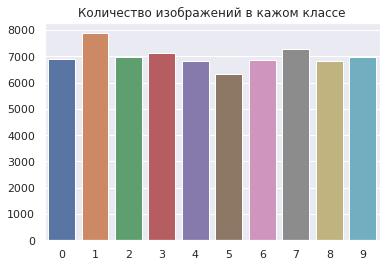

In [4]:
# Loading dataset from Scikit-Datasets
from sklearn.datasets import fetch_openml
images, labels = fetch_openml('mnist_784', version=1, return_X_y=True)
labels = np.array([int(x) for x in labels], dtype=np.int)
print('Loaded {} MNIST samples'.format(images.shape[0]))

# Label indices
label_indices = [None] * 10
for digit in range(10):
    label_indices[digit] = np.where(labels == digit)[0]
    np.random.shuffle(label_indices[digit])

# Plot some statistics
plt.title('Количество изображений в кажом классе')
sns.barplot(x=np.arange(10), y=[label_indices[i].shape[0] for i in range(10)])

In [127]:
# In this notebook, we will limit ourselves with only 6000 images
from sklearn.preprocessing import StandardScaler
X = images[:6000]
X_std = StandardScaler().fit_transform(X)
Y = labels[:6000]

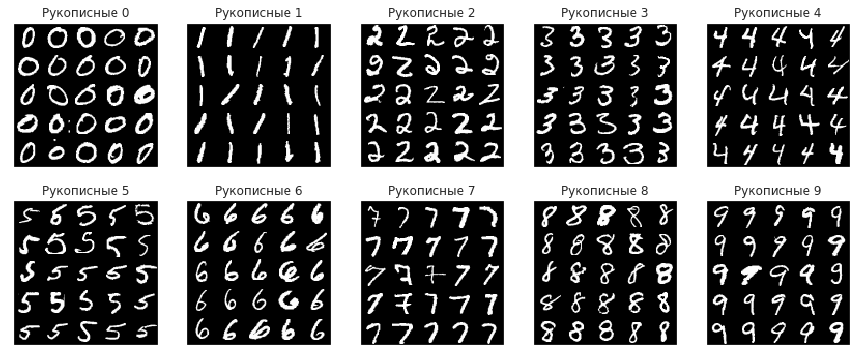

In [128]:
# Let's look at the data
plt.figure(figsize=(15,6))
for digit in range(10):
    cols = []
    for col in range(5):
        digit_indices = label_indices[digit][col*5:(col+1)*5]
        cols.append(
            np.concatenate(images[digit_indices].reshape(5, 28, 28)))
        vis = np.concatenate(cols, axis=1)
    plt.subplot(2, 5, digit + 1), plt.title('Рукописные '+str(digit))
    plt.xticks([]), plt.yticks([])
    plt.imshow(vis, 'gray')

In [129]:
# Calculating Eigenvectors and eigenvalues of Cov matirx
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eigh(cov_mat)

# Sort indices by the descendance of eigenvalues
idx = np.flip(np.argsort(eig_vals))

# Calculation of Explained Variance from the eigenvalues
var_exp = 100 * eig_vals[idx[:100]] / eig_vals.sum() # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

In [130]:
trace1 = go.Scatter(
    x=np.arange(784), y=cum_var_exp, mode='lines+markers',
    name='Cumulative Explained Variance',
    line=dict(shape='spline', color='goldenrod'))
trace2 = go.Scatter(
    x=np.arange(784), y=var_exp, mode='lines+markers',
    name='Individual Explained Variance',
    line=dict(shape='linear', color='black'))

fig = tls.make_subplots()

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 1)
fig.layout.title = 'Explained Variance plots - Full and Zoomed-in'
fig.layout.xaxis = dict(range=[0, 80], title='Feature columns')
fig.layout.yaxis = dict(range=[0, 60], title='Explained Variance')
py.iplot(fig, filename='inset example')
py.offline.plot(fig, filename='/home/vu/Workspace/teaching/pr/01-dimensionality-reduction/eigenvals.html')

This is the format of your plot grid:
[ (1,1) x1,y1 ]



'file:///home/vu/Workspace/teaching/pr/01-dimensionality-reduction/eigenvals.html'

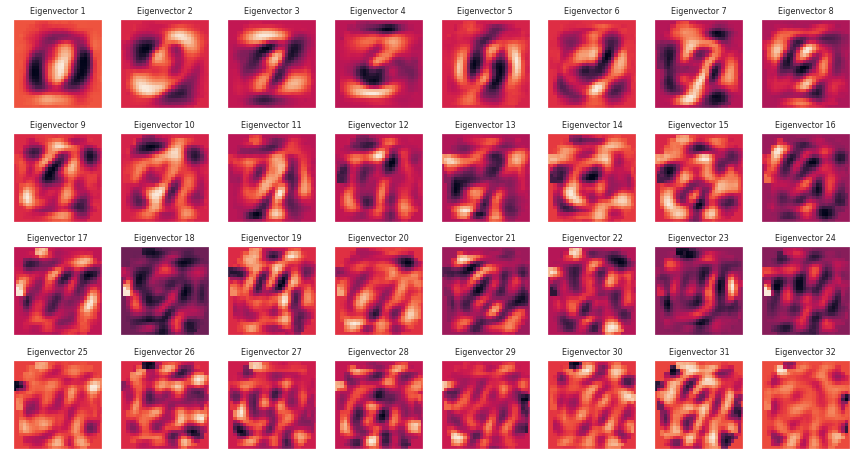

In [131]:
n_row = 4
n_col = 8

# Plot the first 32 eignenvalues
plt.figure(figsize=(15,8))
for i in range(n_row * n_col):
    plt.subplot(n_row, n_col, i+1)
    plt.imshow(eig_vecs.T[idx][i].reshape(28, 28))
    plt.title('Eigenvector {}'.format(i+1), size=8)
    plt.xticks(()), plt.yticks(())
plt.show()

In [175]:
# Invoke SKlearn's PCA method
n_components = 2
pca = PCA(n_components=n_components)
pca.fit(X_std)
X_nd = pca.transform(X_std)

In [228]:
import numpy as np
from scipy.spatial import cKDTree

def prune_iter(X, Y, iterations=50, rprune=0.4, verbose=1):
    X_pruned = X.copy()
    Y_pruned = Y.copy()
    pruned_ids = None
    if verbose==2:
        print(0, len(X_pruned))
    for i in range(int(iterations)):
        tree = cKDTree(X_pruned)
        rows_to_fuse = tree.query_pairs(r=rprune)

        allids = set(np.arange(len(X_pruned)))
        tofuse = set()
        fused = set()
        for a,b in rows_to_fuse:
            tofuse.add(a)
            tofuse.add(b)
            fused.add(a)

        idsleft = allids.difference(tofuse)
        idsleft = idsleft.union(fused)
        idsleft = np.array(list(idsleft), dtype=np.int)
        X_pruned = X_pruned[idsleft]
        Y_pruned = Y_pruned[idsleft]
        if verbose==2:
            print(i+1, len(X_pruned))
    if verbose==1:
        print('{} -> {}'.format(len(X), len(X_pruned)))
    pruned_ids = idsleft
    return X_pruned, Y_pruned


def prune_grid(X, Y, nx=50, ny=50, verbose=1):
    xs = np.linspace(X[:,0].min(), X[:,0].max(), nx)
    ys = np.linspace(X[:,1].min(), X[:,1].max(), ny)
    XS, YS = np.meshgrid(xs, ys)
    dx, dy = xs[1] - xs[0], ys[1] - ys[0]
    XS += np.random.normal(0, dx, XS.shape)
    YS += np.random.normal(0, dy, YS.shape)
    
    dst = np.zeros(shape=(len(xs), len(ys), len(X)))
    col = np.zeros(shape=(len(xs), len(ys)))
    tot = np.zeros(shape=(len(xs), len(ys)))
    
    def l2(x, y):
        return np.sqrt((x - XS)**2 + (y - YS)**2)
    
    pts = set()
    for i in range(len(X)):
        dst[:, :, i] = l2(X[i, 0], X[i, 1])
        pmin = np.unravel_index(np.argmin(dst[:, :, i]), dst[:, :, i].shape)
        col[pmin] += Y[i]
        tot[pmin] += 1
        pts.add(pmin)
    print(len(pts))
    
    X_pruned, Y_pruned = [], []
    for a, b in pts:
        X_pruned.append([XS[a,b], YS[a,b]])
        Y_pruned.append(round(col[(a,b)] / tot[(a,b)]))
    return np.array(X_pruned), np.array(Y_pruned)

X_pruned2, Y_pruned2 = prune_grid(X_nd, Y)

1010


In [230]:
# X_pruned, Y_pruned = prune_iter(X_nd, Y, 100, 0.4)
X_pruned, Y_pruned = prune_grid(X_nd, Y)

trace0 = go.Scattergl(
    x=X_pruned[:,0],
    y=X_pruned[:,1],
    mode='markers',
    text=Y,
    showlegend=False,
    marker=dict(
        size=12,
        color=Y_pruned,
        colorscale='Jet',
        showscale=False,
        line=dict(
            width= 2,
            color='rgb(255, 255, 255)'),
        opacity = 0.8))
data = [trace0]

layout = go.Layout(
    # title='Principal Component Analysis (PCA)',
    hovermode='closest',
    height=400,
    xaxis=dict(
        title='First Principal Component',
        ticklen=5,
        zeroline=False,
        gridwidth=2),
    yaxis=dict(
        title='Second Principal Component',
        ticklen=5,
        gridwidth=2),
    margin=go.layout.Margin(
        l=0,
        r=0,
        b=0,
        t=0,
        pad=4
    ),
    showlegend=True)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='styled-scatter')
txt = py.offline.plot(
    fig,
    # filename='/home/vu/Workspace/teaching/pr/01-dimensionality-reduction/pca.html',
    include_plotlyjs=False,
    output_type='div',
    auto_open=False,
    config={
        #'displayModeBar': False
    })
with open('/home/vu/Workspace/teaching/pr/01-dimensionality-reduction/pca.html', 'w') as f:
    f.write(txt)

1016


In [231]:
from sklearn.cluster import KMeans # KMeans clustering 
# Set a KMeans clustering with 9 components ( 9 chosen sneakily ;) as hopefully we get back our 9 class labels)
kmeans = KMeans(n_clusters=9)
# Compute cluster centers and predict cluster indices

# X_pruned, Y_pruned = prune(X_nd, Y, 100, 0.45)
X_pruned, Y_pruned = prune_grid(X_nd, Y, nx=45, ny=45)
X_clustered = kmeans.fit_predict(X_pruned)

trace_Kmeans = go.Scattergl(x=X_pruned[:, 0], y= X_pruned[:, 1], mode="markers",
                    showlegend=False,
                    text=Y_pruned,
                    marker=dict(
                            size=12,
                            color = X_clustered,
                            colorscale = 'Portland',
                            showscale=False, 
                            line = dict(
            width = 2,
            color = 'rgb(255, 255, 255)'
        )
                   ))

layout = go.Layout(
    # title= 'KMeans Clustering',
    hovermode= 'closest',
    xaxis= dict(
         title= 'First Principal Component',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'Second Principal Component',
        ticklen= 5,
        gridwidth= 2,
    ),
    height=400,
    margin=go.layout.Margin(
        l=0,
        r=0,
        b=0,
        t=0,
        pad=4
    ),
    showlegend= True
)

data = [trace_Kmeans]
fig1 = dict(data=data, layout= layout)
# fig1.append_trace(contour_list)
py.iplot(fig1, filename="svm")
txt = py.offline.plot(
    fig1,
    include_plotlyjs=False,
    output_type='div',
    auto_open=False,
    config={
        #'displayModeBar': False
    })
with open('/home/vu/Workspace/teaching/pr/01-dimensionality-reduction/k-means.html', 'w') as f:
    f.write(txt)

875


In [232]:
lda = LDA(n_components=5)
# Taking in as second argument the Target as labels
X_LDA_2D = lda.fit_transform(X_std, Y)

/home/vu/.local/miniconda3/envs/tf-py36/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



In [254]:
# X_pruned, Y_pruned = prune(X_LDA_2D, Y, 150, 0.7, verbose=1)
X_pruned, Y_pruned = prune_grid(X_LDA_2D, Y)

# Using the Plotly library again
traceLDA = go.Scatter(
    x = X_pruned[:,0],
    y = X_pruned[:,1],
#     name = Target,
#     hoveron = Target,
    mode = 'markers',
    text = Y_pruned,
    showlegend = True,
    marker = dict(
        size = 12,
        color = Y_pruned,
        colorscale ='Jet',
        showscale = False,
        line = dict(
            width = 2,
            color = 'rgb(255, 255, 255)'
        ),
        opacity = 0.8
    )
)
data = [traceLDA]

layout = go.Layout(
    title= 'Linear Discriminant Analysis (LDA)',
    hovermode= 'closest',
    xaxis= dict(
         title= 'First Linear Discriminant',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    height=400,
    yaxis=dict(
        title= 'Second Linear Discriminant',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False,
    margin=go.layout.Margin(
        l=0,
        r=0,
        b=0,
        t=0,
        pad=4
    ),
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='styled-scatter')

txt = py.offline.plot(
    fig,
    include_plotlyjs=False,
    output_type='div',
    auto_open=False,
    config={
        #'displayModeBar': False
    })
with open('/home/vu/Workspace/teaching/pr/01-dimensionality-reduction/lda.html', 'w') as f:
    f.write(txt)

926


In [234]:
# Invoking the t-SNE method
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(X_std)

In [253]:
X_pruned, Y_pruned = prune_iter(tsne_results, Y, iterations=150, rprune=1.8)
#X_pruned, Y_pruned = prune_grid(tsne_results, Y, nx=60,ny=60)

traceTSNE = go.Scatter(
    x = X_pruned[:,0],
    y = X_pruned[:,1],
    #name = Target,
    #hoveron = Target,
    mode = 'markers',
    text = Y_pruned,
    showlegend = True,
    marker = dict(
        size = 12,
        color = Y_pruned,
        colorscale ='Jet',
        showscale = False,
        line = dict(
            width = 2,
            color = 'rgb(255, 255, 255)'
        ),
        opacity = 0.8
    )
)
data = [traceTSNE]

layout = dict(title = 'TSNE (T-Distributed Stochastic Neighbour Embedding)',
              hovermode= 'closest',
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False),
              showlegend= False,
              height=400,
margin=go.layout.Margin(
        l=0,
        r=0,
        b=0,
        t=0,
        pad=4
    ),
             )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='styled-scatter')

txt = py.offline.plot(
    fig,
    include_plotlyjs=False,
    output_type='div',
    auto_open=False,
    config={
        #'displayModeBar': False
    })
with open('/home/vu/Workspace/teaching/pr/01-dimensionality-reduction/t-sne.html', 'w') as f:
    f.write(txt)

6000 -> 1062
